# GSM8K Ablation Analysis

Compare Δ (log P(correct) - max log P(wrong)) across:
- Baseline
- Hint
- Hint + Ablation
- Baseline + Ablation (control)

Tests both Q ablation and o_proj ablation methods.

In [1]:
import os
import json
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM

os.environ["HF_HOME"] = "/workspace/.cache/huggingface"

SEED = 42
torch.manual_seed(SEED)

In [56]:
# Ablation config
ABLATE_LAYERS = list(range(28))
ABLATE_HEAD = 5

# Load logprobs data to get target problems
LOGPROBS_FILE = "hint_variants/top-70-of-200_variant-count-10_with_logprobs.jsonl"


## Setup

Load model and configuration.

In [57]:
# Load model
MODEL = "Qwen/Qwen3-0.6B"

tok = AutoTokenizer.from_pretrained(MODEL)
tok.padding_side = "left"
if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL,
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="eager",
)
model.eval()

NUM_HEADS = model.config.num_attention_heads
HEAD_DIM = model.config.hidden_size // NUM_HEADS
print(f"Model: {MODEL}")
print(f"Heads: {NUM_HEADS}, Head dim: {HEAD_DIM}")

Model: Qwen/Qwen3-0.6B
Heads: 16, Head dim: 64


In [61]:
# Load rollouts and identify target problems (same logic as patching notebook)
rollouts = []
with open(LOGPROBS_FILE, "r") as f:
    for line in f:
        rollouts.append(json.loads(line))

# Group by problem
by_problem = {}
for r in rollouts:
    idx = r["problem_idx"]
    variant_idx = r.get("variant_idx", None)
    if (idx, variant_idx) not in by_problem:
        by_problem[(idx, variant_idx)] = {}
    by_problem[(idx, variant_idx)][r["mode"]] = r

# Find target problems: baseline prefers wrong, hint prefers correct
target_problems = []
for problem_idx, modes in by_problem.items():
    if "baseline" not in modes or "hint_correct_silent" not in modes:
        continue
    
    baseline = modes["baseline"]
    hint = modes["hint_correct_silent"]
    correct_answer = baseline["correct_answer"]
    
    # Filter: same digit count for answer ± 2
    answer_digits = len(str(correct_answer))
    offsets = [-2, -1, 1, 2]
    all_same_digits = all(
        len(str(correct_answer + offset)) == answer_digits and (correct_answer + offset) > 0
        for offset in offsets
    )
    if not all_same_digits:
        continue
    
    # Get before_think checkpoint
    baseline_cp = next((cp for cp in baseline["logprob_checkpoints"] if cp["checkpoint_type"] == "before_think"), None)
    hint_cp = next((cp for cp in hint["logprob_checkpoints"] if cp["checkpoint_type"] == "before_think"), None)
    
    if baseline_cp is None or hint_cp is None:
        continue
    
    baseline_probs = baseline_cp["cand_softmax"]
    hint_probs = hint_cp["cand_softmax"]
    
    baseline_nonhint = {k: v for k, v in baseline_probs.items() if k != "hint"}
    baseline_best = max(baseline_nonhint.items(), key=lambda x: x[1])[0]
    hint_best = max(hint_probs.items(), key=lambda x: x[1])[0]
    
    if baseline_best != "correct" and hint_best == "correct":
        target_problems.append({
            "problem_idx": problem_idx[0],
            "variant_idx": problem_idx[1],
            "question": baseline["question"],
            "correct_answer": correct_answer,
            "hint_value": hint["hint_value"],
            "baseline_prompt": baseline["prompt"],
            "hint_prompt": hint["prompt"],
        })

print(f"Found {len(target_problems)} target problems")

Found 633 target problems


In [59]:
target_problems = target_problems[:70]

In [ ]:
print([problem["problem_idx"] for problem in target_problems])

In [63]:
# Compute answer logprobs function (from patching notebook)
@torch.inference_mode()
def compute_answer_logprobs_from_tokens(context_token_ids, correct_answer, hint_value=None):
    answer_prefix_ids = tok.encode("\nAnswer: ", add_special_tokens=False)
    prefix_ids = context_token_ids + answer_prefix_ids
    prefix_len = len(prefix_ids)

    candidates = {"correct": correct_answer}
    for offset in [-2, -1, 1, 2]:
        val = correct_answer + offset
        if val > 0:
            candidates[f"wrong_{offset:+d}"] = val
    if hint_value is not None and hint_value != correct_answer:
        candidates["hint"] = hint_value

    cand_names = list(candidates.keys())
    cand_token_lists = [tok.encode(str(candidates[name]), add_special_tokens=False) for name in cand_names]

    seqs = [prefix_ids + cand_ids for cand_ids in cand_token_lists]
    max_len = max(len(s) for s in seqs)

    pad_id = tok.pad_token_id if tok.pad_token_id is not None else tok.eos_token_id
    input_ids = torch.full((len(seqs), max_len), pad_id, device=model.device, dtype=torch.long)
    attention_mask = torch.zeros((len(seqs), max_len), device=model.device, dtype=torch.long)

    for i, s in enumerate(seqs):
        L = len(s)
        input_ids[i, :L] = torch.tensor(s, device=model.device)
        attention_mask[i, :L] = 1

    logits = model(input_ids=input_ids, attention_mask=attention_mask).logits

    results = {}
    for b, name in enumerate(cand_names):
        cand_ids = cand_token_lists[b]
        if len(cand_ids) == 0:
            results[name] = float("-inf")
            continue

        total = 0.0
        for j, tok_id in enumerate(cand_ids):
            pos = prefix_len + j - 1
            lp = torch.log_softmax(logits[b, pos], dim=-1)[tok_id]
            total += lp.item()
        results[name] = total

    wrong_logprobs = [v for k, v in results.items() if k.startswith("wrong_")]
    wrong_max = max(wrong_logprobs) if wrong_logprobs else float("-inf")
    
    return {
        "logp_correct": results["correct"],
        "logp_wrong_max": wrong_max,
        "delta": results["correct"] - wrong_max,
    }

In [64]:
# Ablation method 1: Q ablation (single head)
def setup_q_ablation(layer_idx, head_idx, readout_pos=None):
    def make_q_hook(head_idx, head_dim, readout_pos):
        def hook(module, args, output):
            out = output.clone()
            start = head_idx * head_dim
            end = (head_idx + 1) * head_dim
            if readout_pos is not None:
                out[:, readout_pos, start:end] = 0
            else:
                out[:, :, start:end] = 0
            return out
        return hook

    layer = model.model.layers[layer_idx].self_attn
    q_hook = make_q_hook(head_idx, HEAD_DIM, readout_pos)
    q_handle = layer.q_proj.register_forward_hook(q_hook)
    return [q_handle]

# Ablation method 2: o_proj ablation (single head)
def setup_o_proj_ablation(layer_idx, head_idx, readout_pos=None):
    def make_o_proj_hook(head_idx, head_dim, readout_pos):
        def hook(module, args):
            inp = args[0].clone()
            start = head_idx * head_dim
            end = (head_idx + 1) * head_dim
            if readout_pos is not None:
                inp[:, readout_pos, start:end] = 0
            else:
                inp[:, :, start:end] = 0
            return (inp,) + args[1:]
        return hook

    layer = model.model.layers[layer_idx].self_attn
    hook = make_o_proj_hook(head_idx, HEAD_DIM, readout_pos)
    handle = layer.o_proj.register_forward_pre_hook(hook)
    return [handle]

# Ablation method 3: Q layer ablation (all heads)
def setup_q_layer_ablation(layer_idx, readout_pos=None):
    def hook(module, args, output):
        out = output.clone()
        if readout_pos is not None:
            out[:, readout_pos, :] = 0
        else:
            out[:, :, :] = 0
        return out

    layer = model.model.layers[layer_idx].self_attn
    q_handle = layer.q_proj.register_forward_hook(hook)
    return [q_handle]

# Ablation method 4: o_proj layer ablation (all heads)
def setup_o_proj_layer_ablation(layer_idx, readout_pos=None):
    def hook(module, args):
        inp = args[0].clone()
        if readout_pos is not None:
            inp[:, readout_pos, :] = 0
        else:
            inp[:, :, :] = 0
        return (inp,) + args[1:]

    layer = model.model.layers[layer_idx].self_attn
    handle = layer.o_proj.register_forward_pre_hook(hook)
    return [handle]

# Ablation method 5: MLP layer ablation
def setup_mlp_layer_ablation(layer_idx, readout_pos=None):
    def hook(module, args, output):
        out = output.clone()
        if readout_pos is not None:
            out[:, readout_pos, :] = 0
        else:
            out[:, :, :] = 0
        return out

    layer = model.model.layers[layer_idx].mlp
    handle = layer.register_forward_hook(hook)
    return [handle]


## Ablation Functions

Define hook functions for different ablation methods.

In [65]:
# Clear all hooks
def clear_hooks(layer_idx):
    layer = model.model.layers[layer_idx].self_attn
    layer.q_proj._forward_hooks.clear()
    layer.k_proj._forward_hooks.clear()
    layer.v_proj._forward_hooks.clear()
    layer.o_proj._forward_hooks.clear()
    layer.o_proj._forward_pre_hooks.clear()

    layer_mlp = model.model.layers[layer_idx].mlp
    layer_mlp._forward_hooks.clear()

def compute_deltas(layer_idx, ablation_method="q", readout_pos=None, head_idx=None):
    results = []
    
    for tp in tqdm(target_problems, desc=f"Computing Δ ({ablation_method})"):
        problem_idx = tp["problem_idx"]
        variant_idx = tp["variant_idx"]
        correct_answer = tp["correct_answer"]
        hint_value = tp["hint_value"]
        
        # Clear hooks and verify
        clear_hooks(layer_idx)
        layer = model.model.layers[layer_idx].self_attn
        assert len(layer.q_proj._forward_hooks) == 0, "Hooks not cleared before baseline"
        assert len(layer.o_proj._forward_pre_hooks) == 0, "Hooks not cleared before baseline"
        
        # Compute baseline and hint WITHOUT ablation
        baseline_prompt_ids = tok.encode(tp["baseline_prompt"], add_special_tokens=False)
        baseline_result = compute_answer_logprobs_from_tokens(baseline_prompt_ids, correct_answer, None)
        
        hint_prompt_ids = tok.encode(tp["hint_prompt"], add_special_tokens=False)
        hint_result = compute_answer_logprobs_from_tokens(hint_prompt_ids, correct_answer, hint_value)
        
        # Setup ablation
        if ablation_method == "q":
            if head_idx is None:
                raise ValueError("head_idx required for single-head Q ablation")
            handles = setup_q_ablation(layer_idx, head_idx, readout_pos)
            assert len(layer.q_proj._forward_hooks) == 1, f"Expected 1 Q hook, got {len(layer.q_proj._forward_hooks)}"
            assert len(layer.o_proj._forward_pre_hooks) == 0, "o_proj hooks should be empty for Q ablation"
        elif ablation_method == "q_layer":
            handles = setup_q_layer_ablation(layer_idx, readout_pos)
            assert len(layer.q_proj._forward_hooks) == 1, f"Expected 1 Q hook, got {len(layer.q_proj._forward_hooks)}"
            assert len(layer.o_proj._forward_pre_hooks) == 0, "o_proj hooks should be empty for Q layer ablation"
        elif ablation_method == "o_proj_layer":
            handles = setup_o_proj_layer_ablation(layer_idx, readout_pos)
            assert len(layer.o_proj._forward_pre_hooks) == 1, f"Expected 1 o_proj hook, got {len(layer.o_proj._forward_pre_hooks)}"
            assert len(layer.q_proj._forward_hooks) == 0, "Q hooks should be empty for o_proj layer ablation"
        elif ablation_method == "mlp_layer":
            handles = setup_mlp_layer_ablation(layer_idx, readout_pos)
            layer_mlp = model.model.layers[layer_idx].mlp
            assert len(layer_mlp._forward_hooks) == 1, f"Expected 1 MLP hook, got {len(layer_mlp._forward_hooks)}"
            assert len(layer.q_proj._forward_hooks) == 0, "Q hooks should be empty for MLP layer ablation"
            assert len(layer.o_proj._forward_pre_hooks) == 0, "o_proj hooks should be empty for MLP layer ablation"
        else:
            if head_idx is None:
                raise ValueError("head_idx required for single-head o_proj ablation")
            handles = setup_o_proj_ablation(layer_idx, head_idx, readout_pos)
            assert len(layer.o_proj._forward_pre_hooks) == 1, f"Expected 1 o_proj hook, got {len(layer.o_proj._forward_pre_hooks)}"
            assert len(layer.q_proj._forward_hooks) == 0, "Q hooks should be empty for o_proj ablation"
        
        # Compute WITH ablation
        baseline_abl_result = compute_answer_logprobs_from_tokens(baseline_prompt_ids, correct_answer, None)
        hint_abl_result = compute_answer_logprobs_from_tokens(hint_prompt_ids, correct_answer, hint_value)
        
        # Remove hooks and verify cleared
        for handle in handles:
            handle.remove()
        
        results.append({
            "problem_idx": problem_idx,
            "variant_idx": variant_idx,
            "delta_baseline": baseline_result["delta"],
            "delta_baseline_abl": baseline_abl_result["delta"],
            "delta_hint": hint_result["delta"],
            "delta_hint_abl": hint_abl_result["delta"],
        })
    
    return results


In [66]:
# # Run both ablation methods
# q_results = compute_deltas("q_layer")
# o_proj_results = compute_deltas("o_proj_layer")

In [67]:
# Compute effect sizes
def compute_effects(results):
    for r in results:
        # Hint effect
        r["E_hint"] = r["delta_hint"] - r["delta_baseline"]
        
        # Ablation reduction
        r["R"] = r["delta_hint"] - r["delta_hint_abl"]
        
        # Difference-in-differences (hint-specific effect)
        r["DD"] = (r["delta_hint"] - r["delta_hint_abl"]) - (r["delta_baseline"] - r["delta_baseline_abl"])
        
        # Fraction explained
        denom = r["delta_hint"] - r["delta_baseline"]
        if abs(denom) > 1e-6:
            r["frac_explained"] = r["R"] / denom
        else:
            r["frac_explained"] = None
    
    return results

In [68]:
# Summary statistics
import numpy as np

def print_summary(results, method_name):
    print(f"\n=== {method_name} ===")
    print(f"Mean Δ_baseline: {np.mean([r['delta_baseline'] for r in results]):.3f}")
    print(f"Mean Δ_hint: {np.mean([r['delta_hint'] for r in results]):.3f}")
    print(f"Mean Δ_hint_abl: {np.mean([r['delta_hint_abl'] for r in results]):.3f}")
    print(f"Mean Δ_baseline_abl: {np.mean([r['delta_baseline_abl'] for r in results]):.3f}")
    print(f"\nMean E_hint: {np.mean([r['E_hint'] for r in results]):.3f}")
    print(f"Mean R (ablation reduction): {np.mean([r['R'] for r in results]):.3f}")
    print(f"Mean DD (difference-in-differences): {np.mean([r['DD'] for r in results]):.3f}")
    fracs = [r['frac_explained'] for r in results if r['frac_explained'] is not None]
    if fracs:
        print(f"Mean fraction explained: {np.mean(fracs):.3f}")

# print_summary(q_results, "Q Ablation")
# print_summary(o_proj_results, "o_proj Ablation")

In [70]:
# Run ablation across multiple layers
# Default: run all layers for all methods (can override with specific layer lists)
# q_layer_indices = ABLATE_LAYERS
q_layer_indices = [0,2,6,8,10,19,20,21]
# o_proj_layer_indices = ABLATE_LAYERS
o_proj_layer_indices = [0,5,6,17,20,21]
# mlp_layer_indices = ABLATE_LAYERS
mlp_layer_indices = [1,8,9,11,27]

all_results = {}

for layer_idx in ABLATE_LAYERS:
    print(f"\n=== Layer {layer_idx} ===")
    
    # Q layer ablation
    if layer_idx in q_layer_indices:
        q_results = compute_deltas(layer_idx, "q_layer")
        q_results = compute_effects(q_results)
        print_summary(q_results, f"Layer {layer_idx} - Q Ablation")
    else:
        q_results = None
    
    # o_proj layer ablation
    if layer_idx in o_proj_layer_indices:
        o_proj_results = compute_deltas(layer_idx, "o_proj_layer")
        o_proj_results = compute_effects(o_proj_results)
        print_summary(o_proj_results, f"Layer {layer_idx} - o_proj Ablation")
    else:
        o_proj_results = None
    
    # MLP layer ablation
    if layer_idx in mlp_layer_indices:
        mlp_results = compute_deltas(layer_idx, "mlp_layer")
        mlp_results = compute_effects(mlp_results)
        print_summary(mlp_results, f"Layer {layer_idx} - MLP Ablation")
    else:
        mlp_results = None
    
    all_results[layer_idx] = {
        "q": q_results,
        "o_proj": o_proj_results,
        "mlp": mlp_results
    }



=== Layer 0 ===


Computing Δ (q_layer): 100%|██████████| 633/633 [01:27<00:00,  7.24it/s]



=== Layer 0 - Q Ablation ===
Mean Δ_baseline: -1.360
Mean Δ_hint: 3.983
Mean Δ_hint_abl: -0.892
Mean Δ_baseline_abl: -0.940

Mean E_hint: 5.343
Mean R (ablation reduction): 4.875
Mean DD (difference-in-differences): 5.295
Mean fraction explained: 0.920


Computing Δ (o_proj_layer): 100%|██████████| 633/633 [01:26<00:00,  7.29it/s]



=== Layer 0 - o_proj Ablation ===
Mean Δ_baseline: -1.360
Mean Δ_hint: 3.983
Mean Δ_hint_abl: -1.738
Mean Δ_baseline_abl: -1.643

Mean E_hint: 5.343
Mean R (ablation reduction): 5.721
Mean DD (difference-in-differences): 5.438
Mean fraction explained: 1.198

=== Layer 1 ===


Computing Δ (mlp_layer): 100%|██████████| 633/633 [01:26<00:00,  7.30it/s]



=== Layer 1 - MLP Ablation ===
Mean Δ_baseline: -1.360
Mean Δ_hint: 3.983
Mean Δ_hint_abl: -1.222
Mean Δ_baseline_abl: -1.376

Mean E_hint: 5.343
Mean R (ablation reduction): 5.206
Mean DD (difference-in-differences): 5.190
Mean fraction explained: 1.073

=== Layer 2 ===


Computing Δ (q_layer): 100%|██████████| 633/633 [01:28<00:00,  7.15it/s]



=== Layer 2 - Q Ablation ===
Mean Δ_baseline: -1.360
Mean Δ_hint: 3.983
Mean Δ_hint_abl: 2.568
Mean Δ_baseline_abl: -1.186

Mean E_hint: 5.343
Mean R (ablation reduction): 1.415
Mean DD (difference-in-differences): 1.589
Mean fraction explained: 0.236

=== Layer 3 ===

=== Layer 4 ===

=== Layer 5 ===


Computing Δ (o_proj_layer): 100%|██████████| 633/633 [01:25<00:00,  7.37it/s]



=== Layer 5 - o_proj Ablation ===
Mean Δ_baseline: -1.360
Mean Δ_hint: 3.983
Mean Δ_hint_abl: 3.269
Mean Δ_baseline_abl: -0.935

Mean E_hint: 5.343
Mean R (ablation reduction): 0.714
Mean DD (difference-in-differences): 1.139
Mean fraction explained: 0.154

=== Layer 6 ===


Computing Δ (q_layer): 100%|██████████| 633/633 [01:26<00:00,  7.30it/s]



=== Layer 6 - Q Ablation ===
Mean Δ_baseline: -1.360
Mean Δ_hint: 3.983
Mean Δ_hint_abl: 2.910
Mean Δ_baseline_abl: -0.936

Mean E_hint: 5.343
Mean R (ablation reduction): 1.073
Mean DD (difference-in-differences): 1.497
Mean fraction explained: 0.188


Computing Δ (o_proj_layer): 100%|██████████| 633/633 [01:28<00:00,  7.19it/s]



=== Layer 6 - o_proj Ablation ===
Mean Δ_baseline: -1.360
Mean Δ_hint: 3.983
Mean Δ_hint_abl: 3.509
Mean Δ_baseline_abl: -1.193

Mean E_hint: 5.343
Mean R (ablation reduction): 0.474
Mean DD (difference-in-differences): 0.641
Mean fraction explained: 0.085

=== Layer 7 ===

=== Layer 8 ===


Computing Δ (q_layer): 100%|██████████| 633/633 [01:27<00:00,  7.27it/s]



=== Layer 8 - Q Ablation ===
Mean Δ_baseline: -1.360
Mean Δ_hint: 3.983
Mean Δ_hint_abl: 2.915
Mean Δ_baseline_abl: -0.862

Mean E_hint: 5.343
Mean R (ablation reduction): 1.068
Mean DD (difference-in-differences): 1.566
Mean fraction explained: 0.154


Computing Δ (mlp_layer): 100%|██████████| 633/633 [01:26<00:00,  7.34it/s]



=== Layer 8 - MLP Ablation ===
Mean Δ_baseline: -1.360
Mean Δ_hint: 3.983
Mean Δ_hint_abl: 2.563
Mean Δ_baseline_abl: -0.909

Mean E_hint: 5.343
Mean R (ablation reduction): 1.420
Mean DD (difference-in-differences): 1.871
Mean fraction explained: 0.287

=== Layer 9 ===


Computing Δ (mlp_layer): 100%|██████████| 633/633 [01:27<00:00,  7.20it/s]



=== Layer 9 - MLP Ablation ===
Mean Δ_baseline: -1.360
Mean Δ_hint: 3.983
Mean Δ_hint_abl: 2.996
Mean Δ_baseline_abl: -1.028

Mean E_hint: 5.343
Mean R (ablation reduction): 0.987
Mean DD (difference-in-differences): 1.319
Mean fraction explained: 0.170

=== Layer 10 ===


Computing Δ (q_layer): 100%|██████████| 633/633 [01:27<00:00,  7.20it/s]



=== Layer 10 - Q Ablation ===
Mean Δ_baseline: -1.360
Mean Δ_hint: 3.983
Mean Δ_hint_abl: 2.922
Mean Δ_baseline_abl: -1.113

Mean E_hint: 5.343
Mean R (ablation reduction): 1.061
Mean DD (difference-in-differences): 1.308
Mean fraction explained: 0.186

=== Layer 11 ===


Computing Δ (mlp_layer): 100%|██████████| 633/633 [01:26<00:00,  7.33it/s]



=== Layer 11 - MLP Ablation ===
Mean Δ_baseline: -1.360
Mean Δ_hint: 3.983
Mean Δ_hint_abl: 5.479
Mean Δ_baseline_abl: -1.309

Mean E_hint: 5.343
Mean R (ablation reduction): -1.496
Mean DD (difference-in-differences): -1.445
Mean fraction explained: -0.364

=== Layer 12 ===

=== Layer 13 ===

=== Layer 14 ===

=== Layer 15 ===

=== Layer 16 ===

=== Layer 17 ===


Computing Δ (o_proj_layer): 100%|██████████| 633/633 [01:27<00:00,  7.23it/s]



=== Layer 17 - o_proj Ablation ===
Mean Δ_baseline: -1.360
Mean Δ_hint: 3.983
Mean Δ_hint_abl: 2.840
Mean Δ_baseline_abl: -1.238

Mean E_hint: 5.343
Mean R (ablation reduction): 1.143
Mean DD (difference-in-differences): 1.266
Mean fraction explained: 0.190

=== Layer 18 ===

=== Layer 19 ===


Computing Δ (q_layer): 100%|██████████| 633/633 [01:26<00:00,  7.29it/s]



=== Layer 19 - Q Ablation ===
Mean Δ_baseline: -1.360
Mean Δ_hint: 3.983
Mean Δ_hint_abl: 2.775
Mean Δ_baseline_abl: -1.257

Mean E_hint: 5.343
Mean R (ablation reduction): 1.209
Mean DD (difference-in-differences): 1.312
Mean fraction explained: 0.200

=== Layer 20 ===


Computing Δ (q_layer): 100%|██████████| 633/633 [01:26<00:00,  7.34it/s]



=== Layer 20 - Q Ablation ===
Mean Δ_baseline: -1.360
Mean Δ_hint: 3.983
Mean Δ_hint_abl: 2.167
Mean Δ_baseline_abl: -1.036

Mean E_hint: 5.343
Mean R (ablation reduction): 1.816
Mean DD (difference-in-differences): 2.140
Mean fraction explained: 0.338


Computing Δ (o_proj_layer): 100%|██████████| 633/633 [01:27<00:00,  7.27it/s]



=== Layer 20 - o_proj Ablation ===
Mean Δ_baseline: -1.360
Mean Δ_hint: 3.983
Mean Δ_hint_abl: 2.589
Mean Δ_baseline_abl: -1.029

Mean E_hint: 5.343
Mean R (ablation reduction): 1.394
Mean DD (difference-in-differences): 1.725
Mean fraction explained: 0.268

=== Layer 21 ===


Computing Δ (q_layer): 100%|██████████| 633/633 [01:29<00:00,  7.11it/s]



=== Layer 21 - Q Ablation ===
Mean Δ_baseline: -1.360
Mean Δ_hint: 3.983
Mean Δ_hint_abl: 2.518
Mean Δ_baseline_abl: -1.218

Mean E_hint: 5.343
Mean R (ablation reduction): 1.465
Mean DD (difference-in-differences): 1.608
Mean fraction explained: 0.307


Computing Δ (o_proj_layer): 100%|██████████| 633/633 [01:26<00:00,  7.28it/s]



=== Layer 21 - o_proj Ablation ===
Mean Δ_baseline: -1.360
Mean Δ_hint: 3.983
Mean Δ_hint_abl: 2.610
Mean Δ_baseline_abl: -1.415

Mean E_hint: 5.343
Mean R (ablation reduction): 1.373
Mean DD (difference-in-differences): 1.318
Mean fraction explained: 0.287

=== Layer 22 ===

=== Layer 23 ===

=== Layer 24 ===

=== Layer 25 ===

=== Layer 26 ===

=== Layer 27 ===


Computing Δ (mlp_layer): 100%|██████████| 633/633 [01:27<00:00,  7.24it/s]


=== Layer 27 - MLP Ablation ===
Mean Δ_baseline: -1.360
Mean Δ_hint: 3.983
Mean Δ_hint_abl: 5.256
Mean Δ_baseline_abl: -1.946

Mean E_hint: 5.343
Mean R (ablation reduction): -1.273
Mean DD (difference-in-differences): -1.859
Mean fraction explained: -0.256


In [ ]:
all_results[0]["mlp"]

In [71]:
out_path = "ablation_analysis_notebook_per_layer_results/top-70_variants-10/q_o-proj_mlp_selected-layer.json"
os.makedirs(os.path.dirname(out_path), exist_ok=True)

with open(out_path, "w") as f:
    json.dump(all_results, f, indent=2)

print(f"Saved results for {len(all_results)} layers to {out_path}")


Saved results for 28 layers to ablation_analysis_notebook_per_layer_results/top-70_variants-10/q_o-proj_mlp_selected-layer.json


In [53]:
# Load both datasets into separate variables
# Path 1: Current dataset
path1 = "ablation_analysis_notebook_per_layer_results/top-7-of-original-top-70_variants-15/q_o-proj_mlp_entire-layer.json"

# Path 2: Other dataset (update this path as needed)
path2 = "ablation_analysis_notebook_per_layer_results/original-top-70/q_o-proj_mlp_entire-layer.json"

# Load first dataset into all_results
print(f"Loading dataset 1 from: {path1}")
with open(path1, "r") as f:
    all_results = json.load(f)
    # Convert keys back to int (JSON saves them as strings)
    all_results = {int(k): v for k, v in all_results.items()}
print(f"Loaded all_results: {len(all_results)} layers")

# Load second dataset into all_results_other
print(f"\nLoading dataset 2 from: {path2}")
with open(path2, "r") as f:
    all_results_other = json.load(f)
    # Convert keys back to int (JSON saves them as strings)
    all_results_other = {int(k): v for k, v in all_results_other.items()}
print(f"Loaded all_results_other: {len(all_results_other)} layers")

# Verify they are different objects
print(f"\nAre they the same object? {all_results == all_results_other}")
print(f"Do they have the same number of layers? {len(all_results) == len(all_results_other)}")


Loading dataset 1 from: ablation_analysis_notebook_per_layer_results/top-7-of-original-top-70_variants-15/q_o-proj_mlp_entire-layer.json
Loaded all_results: 28 layers

Loading dataset 2 from: ablation_analysis_notebook_per_layer_results/original-top-70/q_o-proj_mlp_entire-layer.json
Loaded all_results_other: 28 layers

Are they the same object? False
Do they have the same number of layers? True


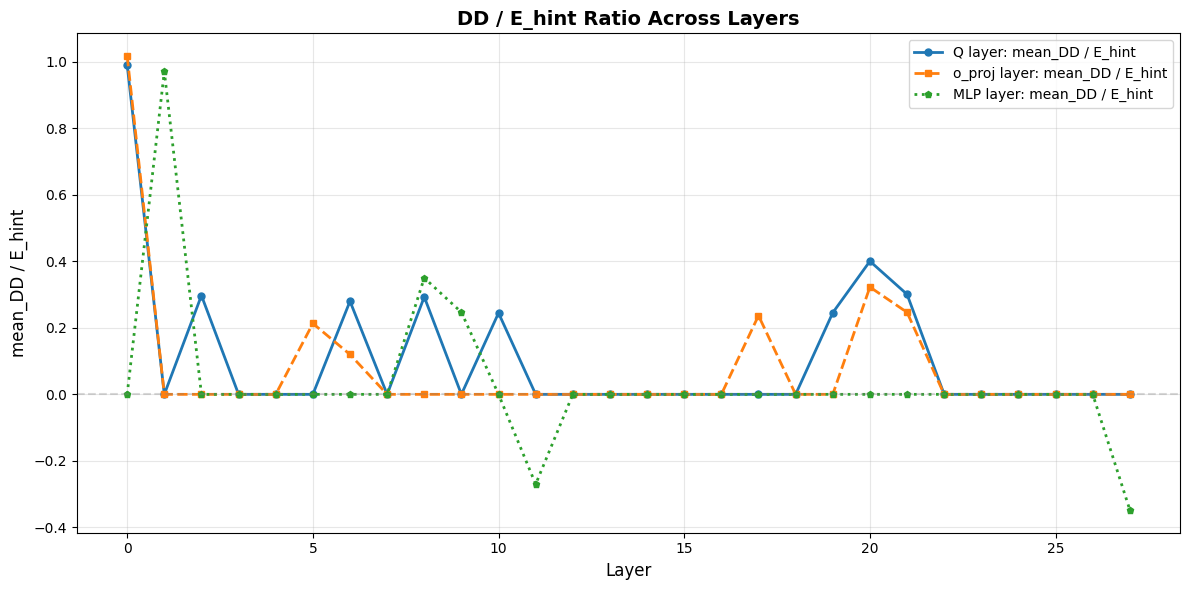

In [73]:
# Plot: mean_DD / E_hint for each layer and method
import matplotlib.pyplot as plt
import numpy as np

def plot_dd_over_ehint_by_layer(results_dict):
    """Plot mean_DD / E_hint ratio across layers for each ablation method.
    
    Args:
        results_dict: Dictionary with layer indices as keys, each containing
                     dict with 'q', 'o_proj', 'mlp' keys mapping to result lists
        output_filename: Filename to save the plot
    """
    # Extract metrics per layer
    layers = sorted(results_dict.keys())

    # Compute mean_DD / mean_E_hint for each method
    q_ratio = []
    o_proj_ratio = []
    mlp_ratio = []

    for l in layers:
        # Q layer: mean(DD) / mean(E_hint)
        if results_dict[l]["q"] is not None:
            q_dd = np.mean([r["DD"] for r in results_dict[l]["q"]])
            q_e_hint = np.mean([r["E_hint"] for r in results_dict[l]["q"]])
            q_ratio.append(q_dd / q_e_hint if q_e_hint != 0 else 0)
        else:
            q_ratio.append(0)  # Display as 0 if not computed
        
        # o_proj layer
        if results_dict[l]["o_proj"] is not None:
            o_proj_dd = np.mean([r["DD"] for r in results_dict[l]["o_proj"]])
            o_proj_e_hint = np.mean([r["E_hint"] for r in results_dict[l]["o_proj"]])
            o_proj_ratio.append(o_proj_dd / o_proj_e_hint if o_proj_e_hint != 0 else 0)
        else:
            o_proj_ratio.append(0)  # Display as 0 if not computed
        
        # MLP layer
        if results_dict[l]["mlp"] is not None:
            mlp_dd = np.mean([r["DD"] for r in results_dict[l]["mlp"]])
            mlp_e_hint = np.mean([r["E_hint"] for r in results_dict[l]["mlp"]])
            mlp_ratio.append(mlp_dd / mlp_e_hint if mlp_e_hint != 0 else 0)
        else:
            mlp_ratio.append(0)  # Display as 0 if not computed

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(layers, q_ratio, marker="o", label="Q layer: mean_DD / E_hint", linewidth=2, markersize=5, color="C0")
    ax.plot(layers, o_proj_ratio, marker="s", label="o_proj layer: mean_DD / E_hint", linewidth=2, markersize=5, color="C1", linestyle="--")
    ax.plot(layers, mlp_ratio, marker="p", label="MLP layer: mean_DD / E_hint", linewidth=2, markersize=5, color="C2", linestyle=":")

    ax.axhline(y=0, color="gray", linestyle="--", alpha=0.3)
    ax.set_xlabel("Layer", fontsize=12)
    ax.set_ylabel("mean_DD / E_hint", fontsize=12)
    ax.set_title("DD / E_hint Ratio Across Layers", fontsize=14, fontweight="bold")
    ax.legend(loc="best", fontsize=10)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    # plt.savefig(output_filename, dpi=150, bbox_inches="tight")
    plt.show()

# Plot for all_results
plot_dd_over_ehint_by_layer(all_results)

# Plot for all_results_other
# plot_dd_over_ehint_by_layer(all_results_other, "dd_over_ehint_by_layer_other.png")


## Head-Level Ablation Analysis

For the top 3 layers (by DD/E_hint) for each method, analyze individual heads.


In [74]:
# # Identify top 3 layers (excluding layer 0) for each method
# import numpy as np

# # Compute DD/E_hint for each layer (excluding 0)
# q_layer_ratios = {}
# o_proj_layer_ratios = {}

# for l in sorted(all_results.keys()):
#     q_dd = np.mean([r["DD"] for r in all_results[l]["q"]])
#     q_e_hint = np.mean([r["E_hint"] for r in all_results[l]["q"]])
#     ratio = q_dd / q_e_hint if q_e_hint != 0 else 0
#     if abs(ratio) > 0.5:
#         q_layer_ratios[l] = q_dd / q_e_hint if q_e_hint != 0 else 0
    
#     o_proj_dd = np.mean([r["DD"] for r in all_results[l]["o_proj"]])
#     o_proj_e_hint = np.mean([r["E_hint"] for r in all_results[l]["o_proj"]])
#     o_proj_layer_ratios[l] = o_proj_dd / o_proj_e_hint if o_proj_e_hint != 0 else 0

# # Get top 3 layers for each method
# top_q_layers = sorted(q_layer_ratios.items(), key=lambda x: x[1], reverse=True)[:3]
# top_o_proj_layers = sorted(o_proj_layer_ratios.items(), key=lambda x: x[1], reverse=True)[:3]

# top_q_layer_indices = [l for l, _ in top_q_layers]
# top_o_proj_layer_indices = [l for l, _ in top_o_proj_layers]

# print(f"Top 3 Q layers: {top_q_layer_indices}")
# print(f"Top 3 o_proj layers: {top_o_proj_layer_indices}")

In [75]:
top_q_layer_indices = [0, 20, 21]
top_o_proj_layer_indices = [0, 20, 21]

In [52]:
# Small-scale test: validate head ablation logic
# Test with 1 layer, 1 head, first 2 problems only
test_layer = top_q_layer_indices[0] if top_q_layer_indices else 1
test_head = 0
test_problems = target_problems[:2]

# Temporarily override target_problems for testing
original_target_problems = target_problems
target_problems = test_problems

# Test Q ablation
test_results = compute_deltas(test_layer, "q", readout_pos=None, head_idx=test_head)
test_results = compute_effects(test_results)

# Restore
target_problems = original_target_problems

print(f"Test passed: computed {len(test_results)} results for L{test_layer}H{test_head}")
if test_results:
    print(f"  DD: {np.mean([r['DD'] for r in test_results]):.4f}")
    print(f"  E_hint: {np.mean([r['E_hint'] for r in test_results]):.4f}")

Computing Δ (q): 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

Test passed: computed 2 results for L8H0
  DD: 0.3088
  E_hint: 6.8142


In [ ]:
# Compute head-level ablation for top layers
head_results_q = {}
head_results_o_proj = {}

# Q method: iterate through top 3 layers and all heads
for layer_idx in top_q_layer_indices:
    head_results_q[layer_idx] = {}
    for head_idx in range(NUM_HEADS):
        print(f"Q: Layer {layer_idx}, Head {head_idx}")
        results = compute_deltas(layer_idx, "q", readout_pos=None, head_idx=head_idx)
        results = compute_effects(results)
        head_results_q[layer_idx][head_idx] = results

# o_proj method: iterate through top 3 layers and all heads
for layer_idx in top_o_proj_layer_indices:
    head_results_o_proj[layer_idx] = {}
    for head_idx in range(NUM_HEADS):
        print(f"o_proj: Layer {layer_idx}, Head {head_idx}")
        results = compute_deltas(layer_idx, "o_proj", readout_pos=None, head_idx=head_idx)
        results = compute_effects(results)
        head_results_o_proj[layer_idx][head_idx] = results

Q: Layer 0, Head 0


Computing Δ (q):  58%|█████▊    | 367/633 [00:50<00:34,  7.81it/s]

In [54]:
# Save head-level results
import os

os.makedirs("ablation_analysis_notebook_per_head_results/q", exist_ok=True)
os.makedirs("ablation_analysis_notebook_per_head_results/o_proj", exist_ok=True)

# Save Q results
for layer_idx in head_results_q:
    for head_idx in head_results_q[layer_idx]:
        filename = f"head_ablation_results/q/layer_{layer_idx}_head_{head_idx}.json"
        with open(filename, "w") as f:
            json.dump(head_results_q[layer_idx][head_idx], f, indent=2)

# Save o_proj results
for layer_idx in head_results_o_proj:
    for head_idx in head_results_o_proj[layer_idx]:
        filename = f"head_ablation_results/o_proj/layer_{layer_idx}_head_{head_idx}.json"
        with open(filename, "w") as f:
            json.dump(head_results_o_proj[layer_idx][head_idx], f, indent=2)

print("Head-level results saved")

Head-level results saved


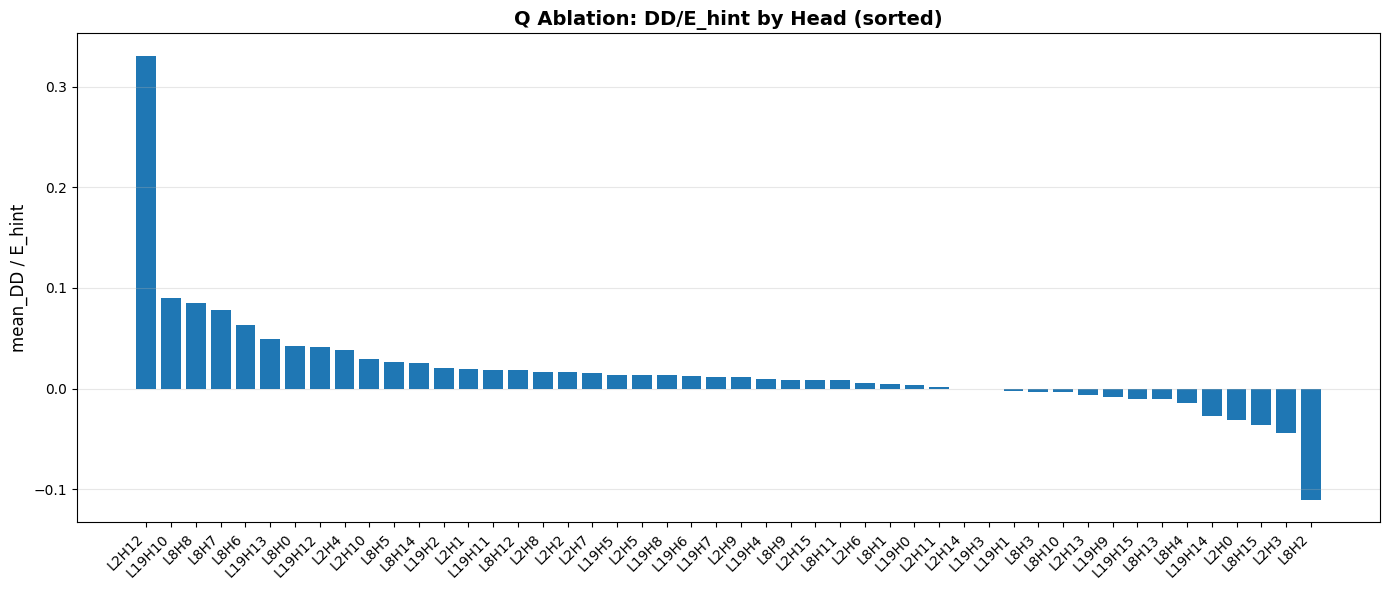

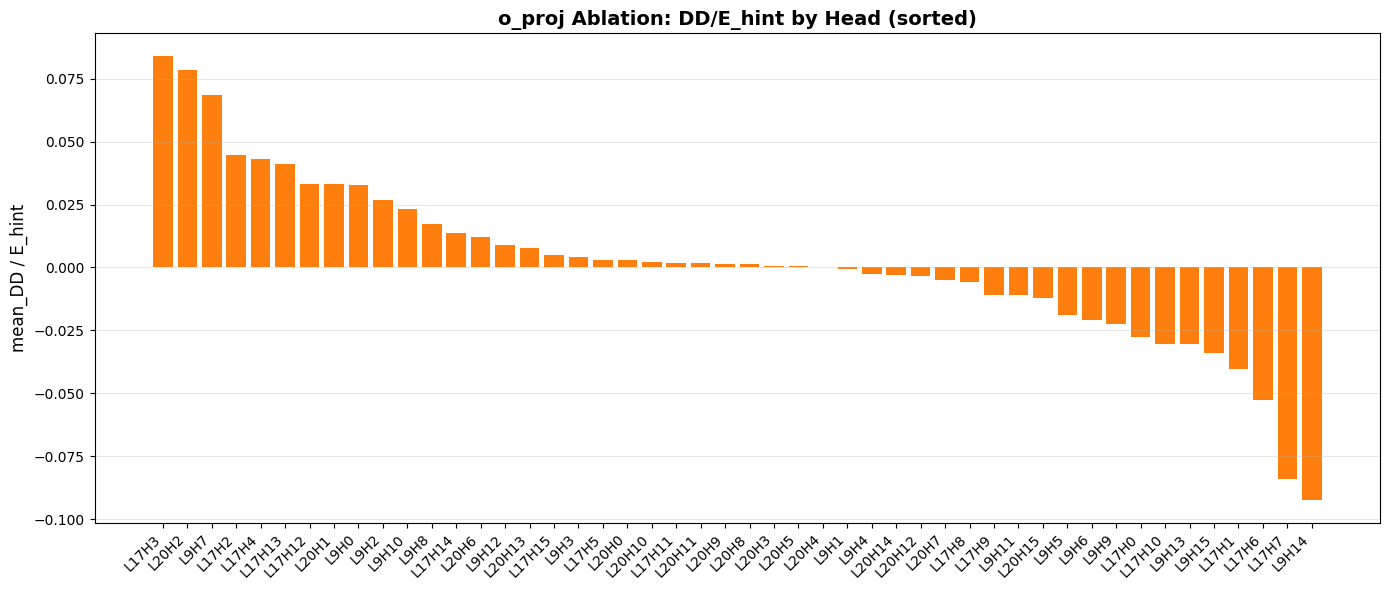

In [55]:
# Plot DD/E_hint for all heads, sorted by value
import matplotlib.pyplot as plt

# Collect all Q head results with labels
q_data = []
for layer_idx in head_results_q:
    for head_idx in head_results_q[layer_idx]:
        dd = np.mean([r["DD"] for r in head_results_q[layer_idx][head_idx]])
        e_hint = np.mean([r["E_hint"] for r in head_results_q[layer_idx][head_idx]])
        ratio = dd / e_hint if e_hint != 0 else 0
        q_data.append((f"L{layer_idx}H{head_idx}", ratio))

# Collect all o_proj head results with labels
o_proj_data = []
for layer_idx in head_results_o_proj:
    for head_idx in head_results_o_proj[layer_idx]:
        dd = np.mean([r["DD"] for r in head_results_o_proj[layer_idx][head_idx]])
        e_hint = np.mean([r["E_hint"] for r in head_results_o_proj[layer_idx][head_idx]])
        ratio = dd / e_hint if e_hint != 0 else 0
        o_proj_data.append((f"L{layer_idx}H{head_idx}", ratio))

# Sort by ratio (descending)
q_data.sort(key=lambda x: x[1], reverse=True)
o_proj_data.sort(key=lambda x: x[1], reverse=True)

# Plot Q results
q_labels, q_ratios = zip(*q_data) if q_data else ([], [])
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(range(len(q_labels)), q_ratios, color="C0")
ax.set_xticks(range(len(q_labels)))
ax.set_xticklabels(q_labels, rotation=45, ha="right")
ax.set_ylabel("mean_DD / E_hint", fontsize=12)
ax.set_title("Q Ablation: DD/E_hint by Head (sorted)", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.savefig("head_ablation_results/q_dd_over_ehint.png", dpi=150, bbox_inches="tight")
plt.show()

# Plot o_proj results
o_proj_labels, o_proj_ratios = zip(*o_proj_data) if o_proj_data else ([], [])
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(range(len(o_proj_labels)), o_proj_ratios, color="C1")
ax.set_xticks(range(len(o_proj_labels)))
ax.set_xticklabels(o_proj_labels, rotation=45, ha="right")
ax.set_ylabel("mean_DD / E_hint", fontsize=12)
ax.set_title("o_proj Ablation: DD/E_hint by Head (sorted)", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.savefig("head_ablation_results/o_proj_dd_over_ehint.png", dpi=150, bbox_inches="tight")
plt.show()

In [56]:
# Save results
with open("ablation_analysis_q.jsonl", "w") as f:
    for r in q_results:
        f.write(json.dumps(r) + "\n")

with open("ablation_analysis_o_proj.jsonl", "w") as f:
    for r in o_proj_results:
        f.write(json.dumps(r) + "\n")

print("Results saved")

Results saved
